In [1]:
import random

import matplotlib.pyplot as plt
import numpy as np
import torch
import torchmetrics
from helper_functions import plot_decision_boundary
from sklearn.datasets import make_blobs, make_circles
from sklearn.model_selection import train_test_split
from torch import nn, optim

In [2]:
device = "cuda" if torch.cuda.is_available() else "cpu"

In [3]:
def set_random_seed(seed: int = 42) -> None:
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)

In [4]:
set_random_seed(42)

In [5]:
n_samples = 1000
X, y = make_circles(n_samples, noise=0.03)

X.shape, y.shape

((1000, 2), (1000,))

In [6]:
X = torch.from_numpy(X).type(torch.float)
y = torch.from_numpy(y).type(torch.float)

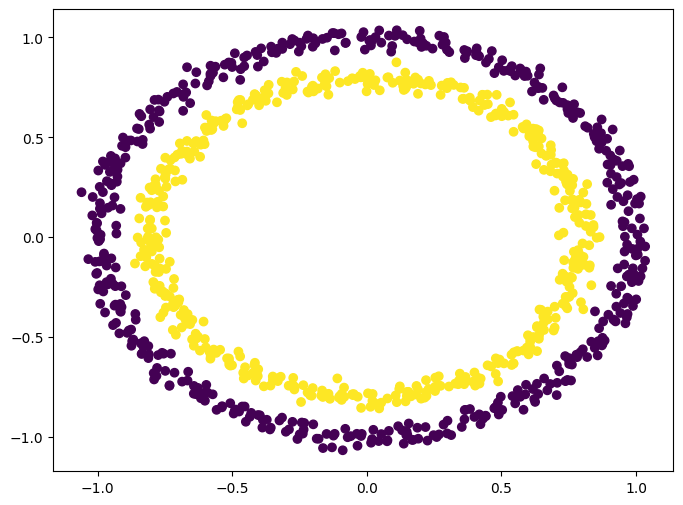

In [7]:
plt.figure(figsize=(8, 6))
plt.scatter(x=X[:, 0], y=X[:, 1], c=y)

In [8]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

In [9]:
class CircleModel(nn.Module):
    def __init__(self, in_features: int, out_features: int) -> None:
        super().__init__()
        self.linear_1 = nn.Linear(in_features, 32)
        self.linear_2 = nn.Linear(32, 64)
        self.linear_3 = nn.Linear(64, out_features)
        self.relu = nn.ReLU()

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        x = self.linear_1(x)
        x = self.relu(x)
        x = self.linear_2(x)
        x = self.relu(x)
        x = self.linear_3(x)

        return x

In [10]:
model = CircleModel(2, 1).to(device)

In [11]:
model.state_dict()

OrderedDict([('linear_1.weight',
              tensor([[ 0.5406,  0.5869],
                      [-0.1657,  0.6496],
                      [-0.1549,  0.1427],
                      [-0.3443,  0.4153],
                      [ 0.6233, -0.5188],
                      [ 0.6146,  0.1323],
                      [ 0.5224,  0.0958],
                      [ 0.3410, -0.0998],
                      [ 0.5451,  0.1045],
                      [-0.3301,  0.1802],
                      [-0.3258, -0.0829],
                      [-0.2872,  0.4691],
                      [-0.5582, -0.3260],
                      [-0.1997, -0.4252],
                      [ 0.0667, -0.6984],
                      [ 0.6386, -0.6007],
                      [ 0.5459,  0.1177],
                      [-0.2296,  0.4370],
                      [ 0.1102,  0.5713],
                      [ 0.0773, -0.2230],
                      [ 0.1900, -0.1918],
                      [ 0.2976,  0.6313],
                      [ 0.4087, -0.3091],
 

In [12]:
model.eval()
with torch.inference_mode():

    y_pred = model(X_test)



y_pred[:5], y_test[:5]

(tensor([[0.1391],
         [0.0202],
         [0.0160],
         [0.0454],
         [0.1330]]),
 tensor([1., 0., 0., 0., 1.]))

In [13]:
loss_fn = nn.BCEWithLogitsLoss()
optimizer = optim.Adam(model.parameters())


In [14]:
def accuracy_fn(y_pred: torch.Tensor, y_true: torch.Tensor) -> float:
    equal = torch.eq(y_true, y_pred).sum().item()
    return equal / len(y_pred) * 100

In [15]:
epochs = 1000

train_loss_values = []
test_loss_values = []
train_accuracy_values = []
test_accuracy_values = []

for epoch in range(epochs):
    model.train()

    y_logits = model(X_train).squeeze()
    y_pred = torch.round(torch.sigmoid(y_logits))

    loss = loss_fn(y_logits, y_train)
    acc = accuracy_fn(y_pred, y_train)
    train_loss_values.append(loss.item())
    train_accuracy_values.append(acc)

    # Backpropagation
    loss.backward()
    optimizer.step()
    optimizer.zero_grad()

    model.eval()
    with torch.inference_mode():
        test_logits = model(X_test).squeeze()
        test_pred = torch.round(torch.sigmoid(test_logits))

        test_loss = loss_fn(test_logits, y_test)
        test_accuracy = accuracy_fn(test_pred, y_test)
        test_loss_values.append(test_loss.item())
        test_accuracy_values.append(test_accuracy)

        if epoch % 100 == 0:
            print(
                f"Train loss: {loss} | Train accuracy: {acc:.2f}% | Test loss: {test_loss} | Test accuracy: {test_accuracy:.2f}%"
            )

Train loss: 0.6937475800514221 | Train accuracy: 50.00% | Test loss: 0.691902756690979 | Test accuracy: 54.50%
Train loss: 0.5366542935371399 | Train accuracy: 99.00% | Test loss: 0.5312678813934326 | Test accuracy: 100.00%
Train loss: 0.15081322193145752 | Train accuracy: 99.88% | Test loss: 0.13862362504005432 | Test accuracy: 100.00%
Train loss: 0.04751552268862724 | Train accuracy: 100.00% | Test loss: 0.04233929514884949 | Test accuracy: 100.00%
Train loss: 0.023118162527680397 | Train accuracy: 100.00% | Test loss: 0.02176343835890293 | Test accuracy: 100.00%
Train loss: 0.013720452785491943 | Train accuracy: 100.00% | Test loss: 0.01416974700987339 | Test accuracy: 100.00%
Train loss: 0.009204528294503689 | Train accuracy: 100.00% | Test loss: 0.010552537627518177 | Test accuracy: 100.00%
Train loss: 0.006651547737419605 | Train accuracy: 100.00% | Test loss: 0.008755653165280819 | Test accuracy: 100.00%
Train loss: 0.005025623831897974 | Train accuracy: 100.00% | Test loss: 0.0

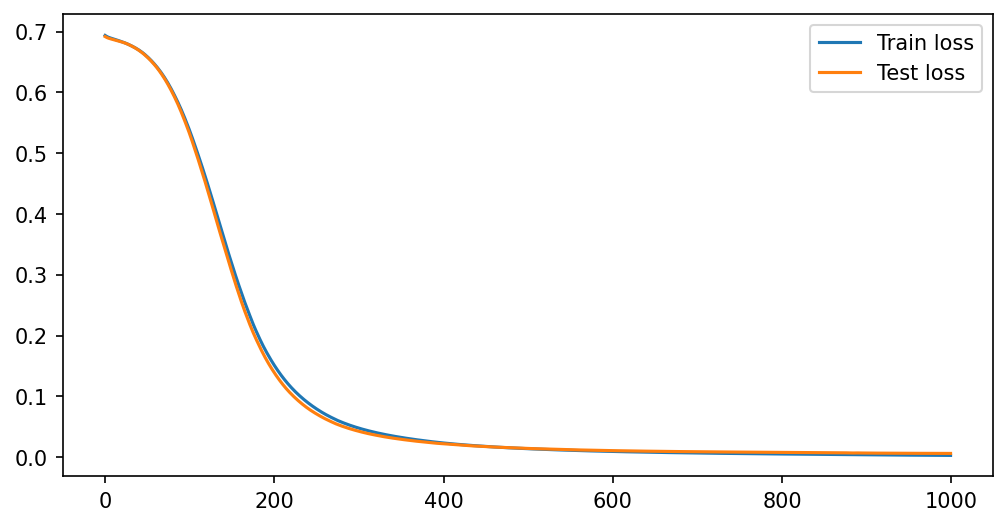

In [16]:
plt.figure(figsize=(8, 4), dpi=150)
plt.plot(range(epochs), train_loss_values, label="Train loss")
plt.plot(range(epochs), test_loss_values, label="Test loss")
plt.legend()


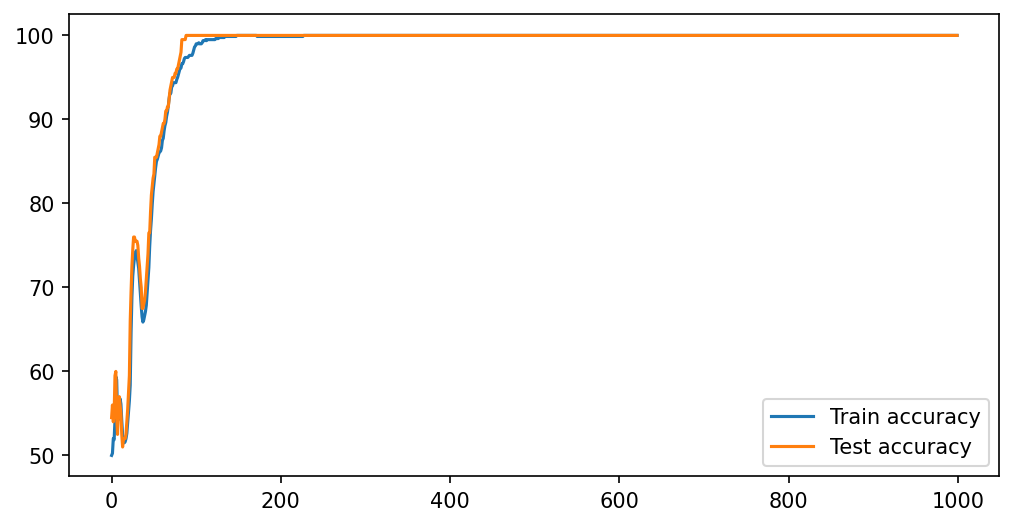

In [17]:
plt.figure(figsize=(8, 4), dpi=150)
plt.plot(range(epochs), train_accuracy_values, label="Train accuracy")
plt.plot(range(epochs), test_accuracy_values, label="Test accuracy")
plt.legend()

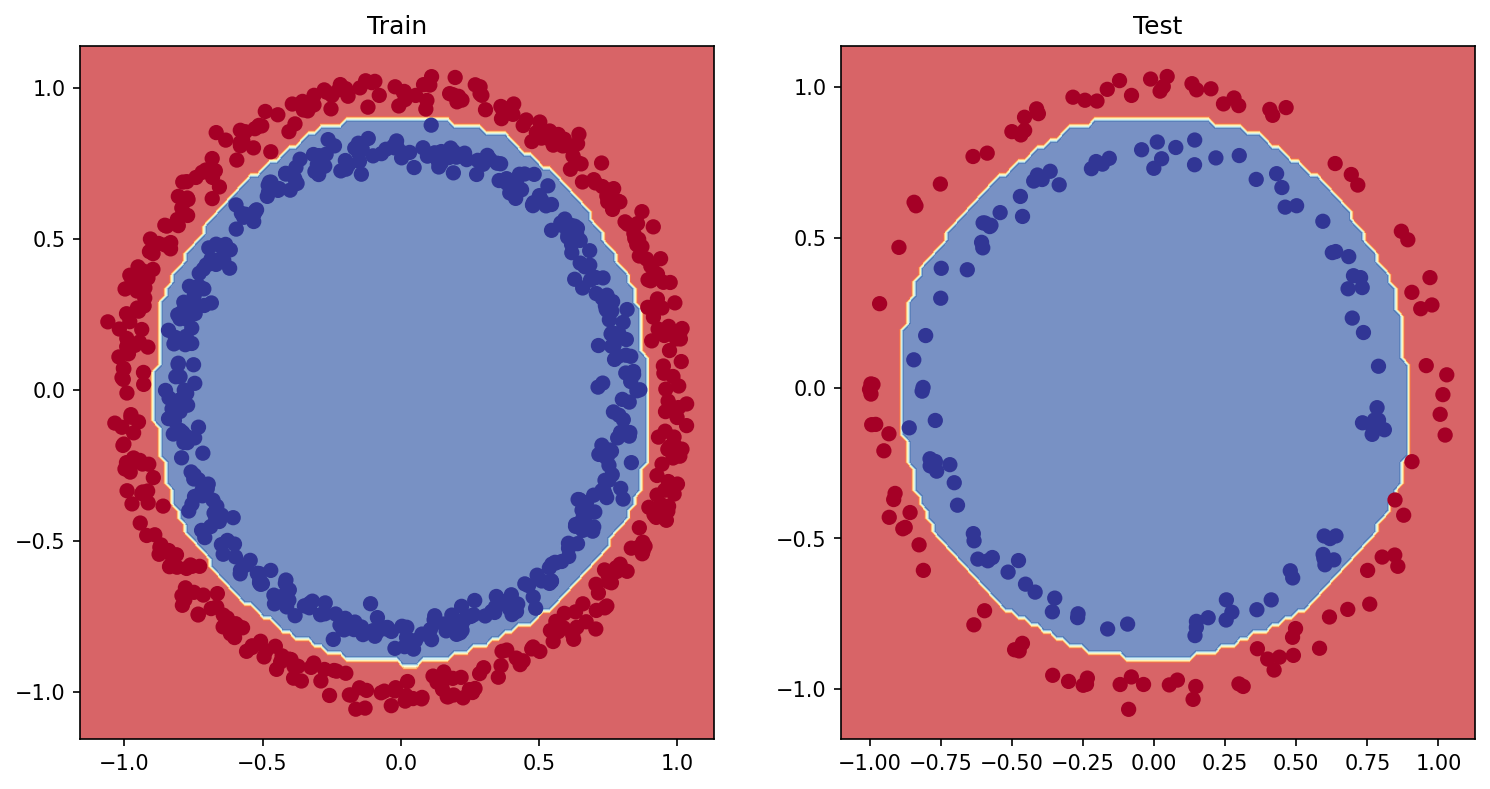

In [18]:
plt.figure(figsize=(12, 6), dpi=150)
plt.subplot(1, 2, 1)
plt.title("Train")
plot_decision_boundary(model, X_train, y_train)

plt.subplot(1, 2, 2)
plt.title("Test")
plot_decision_boundary(model, X_test, y_test)

### Multiclass Classification


In [19]:
n_sample = 2000
n_features = 2
n_classes = 4

X_blob, y_blob = make_blobs(
    n_samples=n_samples,
    n_features=n_features,
    centers=n_classes,
    cluster_std=1.5,
    random_state=42,
)

X_blob, y_blob = torch.from_numpy(X_blob).type(torch.float), torch.from_numpy(
    y_blob
).type(torch.LongTensor)

print(X_blob[:5], y_blob[:5])

tensor([[-8.4134,  6.9352],
        [-5.7665, -6.4312],
        [-6.0421, -6.7661],
        [ 3.9508,  0.6984],
        [ 4.2505, -0.2815]]) tensor([3, 2, 2, 1, 1])


In [20]:
X_blob_train, X_blob_test, y_blob_train, y_blob_test = train_test_split(
    X_blob, y_blob, test_size=0.2, random_state=42
)


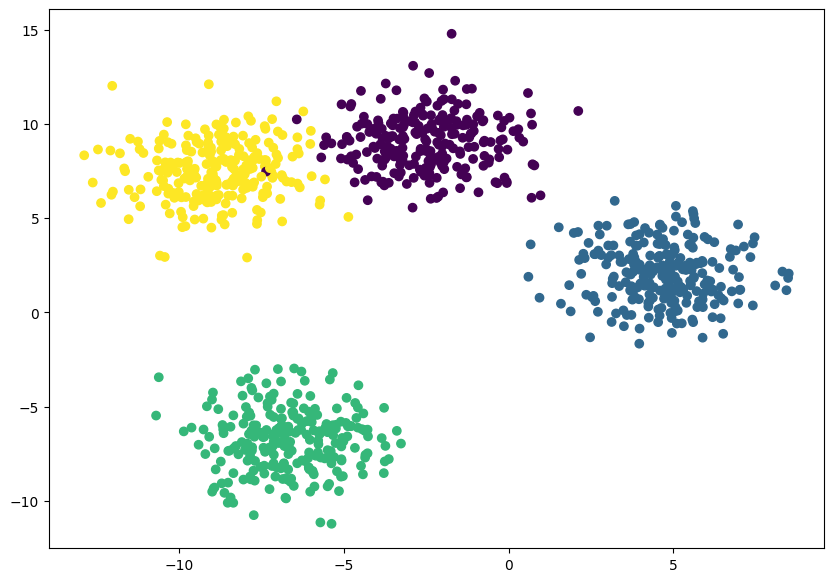

In [21]:
plt.figure(figsize=(10, 7))
plt.scatter(X_blob[:, 0], X_blob[:, 1], c=y_blob)

In [22]:
class BlobModel(nn.Module):
    def __init__(
        self, in_features: int = n_features, out_features: int = n_classes
    ) -> None:
        super().__init__()
        self.fc = nn.Sequential(
            nn.Linear(in_features, 16),
            nn.ReLU(),
            nn.Linear(16, 32),
            nn.ReLU(),
            nn.Linear(32, out_features),
        )

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        return self.fc(x)

In [23]:
blob_model = BlobModel()

In [24]:
blob_model.state_dict()

OrderedDict([('fc.0.weight',
              tensor([[ 0.3512,  0.3642],
                      [-0.6732, -0.6644],
                      [-0.5427,  0.2212],
                      [-0.6116, -0.5398],
                      [-0.3427, -0.6517],
                      [ 0.0010,  0.1020],
                      [-0.4138,  0.4630],
                      [-0.2684, -0.1991],
                      [ 0.5387,  0.6071],
                      [-0.0811, -0.5076],
                      [-0.3547,  0.0900],
                      [ 0.4145,  0.3520],
                      [-0.3122, -0.6685],
                      [-0.6188, -0.2250],
                      [ 0.0089, -0.3176],
                      [-0.5591,  0.0745]])),
             ('fc.0.bias',
              tensor([-0.5613, -0.5430, -0.5748, -0.1916,  0.6246,  0.2764, -0.0838,  0.1455,
                       0.2816,  0.0041, -0.5703, -0.4357, -0.4804, -0.0180, -0.6473, -0.1286])),
             ('fc.2.weight',
              tensor([[-9.1418e-02,  2.4534e-01, 

In [25]:
loss_fn = nn.CrossEntropyLoss()
optimizer = optim.Adam(blob_model.parameters())


In [26]:
epochs = 1000

metric = torchmetrics.Accuracy(task="multiclass", num_classes=4)
train_loss_values = []
test_loss_values = []
train_accuracy_values = []
test_accuracy_values = []

for epoch in range(epochs):
    blob_model.train()

    y_logits = blob_model(X_blob_train).squeeze()
    y_pred = torch.softmax(y_logits, dim=1).argmax(dim=1)

    loss = loss_fn(y_logits, y_blob_train)
    acc = metric(y_pred, y_blob_train)
    train_loss_values.append(loss.item())
    train_accuracy_values.append(acc.item())

    # Backpropagation
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    blob_model.eval()
    with torch.inference_mode():
        test_logits = blob_model(X_blob_test).squeeze()
        test_pred = torch.softmax(test_logits, dim=1).argmax(dim=1)

        test_loss = loss_fn(test_logits, y_blob_test)
        test_accuracy = metric(test_pred, y_blob_test)
        test_loss_values.append(test_loss.item())
        test_accuracy_values.append(test_accuracy.item())

        if epoch % 100 == 0:
            print(
                f"Train loss: {loss} | Train accuracy: {acc:.2f}% | Test loss: {test_loss} | Test accuracy: {test_accuracy:.2f}%"
            )

Train loss: 1.6371856927871704 | Train accuracy: 0.25% | Test loss: 1.6488384008407593 | Test accuracy: 0.26%
Train loss: 0.16500455141067505 | Train accuracy: 0.99% | Test loss: 0.14233919978141785 | Test accuracy: 1.00%
Train loss: 0.04878738895058632 | Train accuracy: 0.99% | Test loss: 0.03650762885808945 | Test accuracy: 1.00%
Train loss: 0.032688409090042114 | Train accuracy: 0.99% | Test loss: 0.021884892135858536 | Test accuracy: 1.00%
Train loss: 0.02572484314441681 | Train accuracy: 0.99% | Test loss: 0.015481456182897091 | Test accuracy: 1.00%
Train loss: 0.02347750961780548 | Train accuracy: 0.99% | Test loss: 0.013044154271483421 | Test accuracy: 1.00%
Train loss: 0.022371087223291397 | Train accuracy: 0.99% | Test loss: 0.011817105114459991 | Test accuracy: 1.00%
Train loss: 0.02156692184507847 | Train accuracy: 0.99% | Test loss: 0.01100534200668335 | Test accuracy: 1.00%
Train loss: 0.02094762772321701 | Train accuracy: 0.99% | Test loss: 0.010397981852293015 | Test acc

In [27]:
# metric on all batches using custom accumulation
acc = metric.compute()
print(f"Accuracy on all data: {acc}")

# Resetting internal state such that metric ready for new data
metric.reset()


Accuracy on all data: 0.9737250208854675


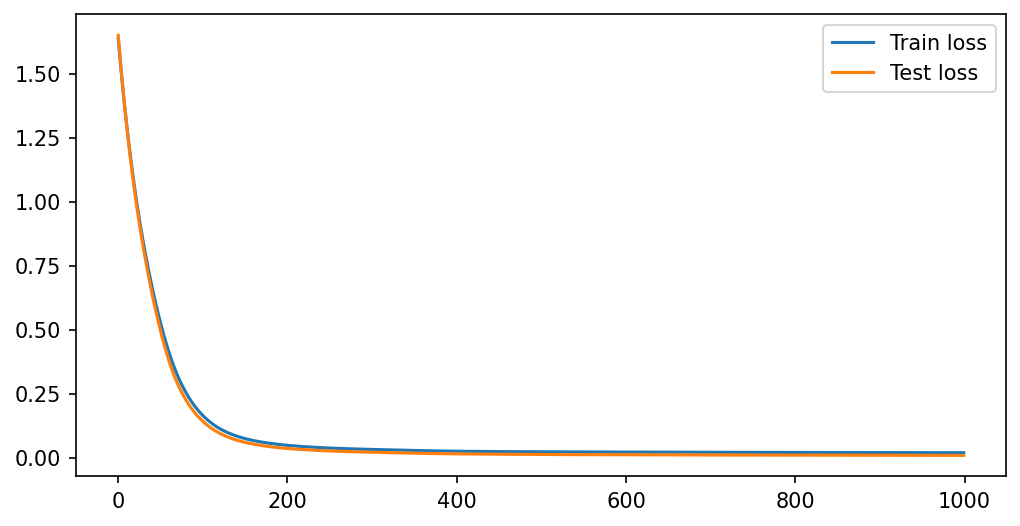

In [28]:
plt.figure(figsize=(8, 4), dpi=150)
plt.plot(range(epochs), train_loss_values, label="Train loss")
plt.plot(range(epochs), test_loss_values, label="Test loss")
plt.legend()


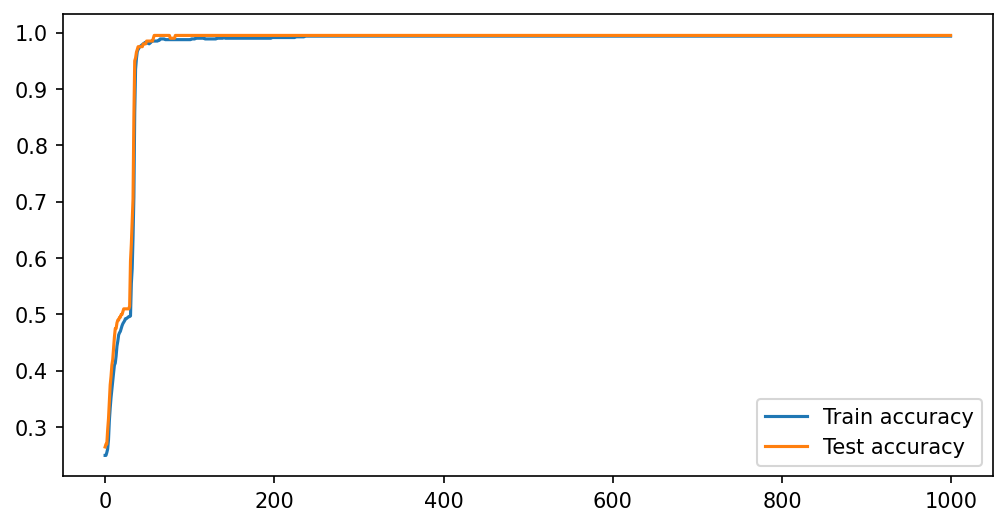

In [29]:
plt.figure(figsize=(8, 4), dpi=150)
plt.plot(range(epochs), train_accuracy_values, label="Train accuracy")
plt.plot(range(epochs), test_accuracy_values, label="Test accuracy")
plt.legend()


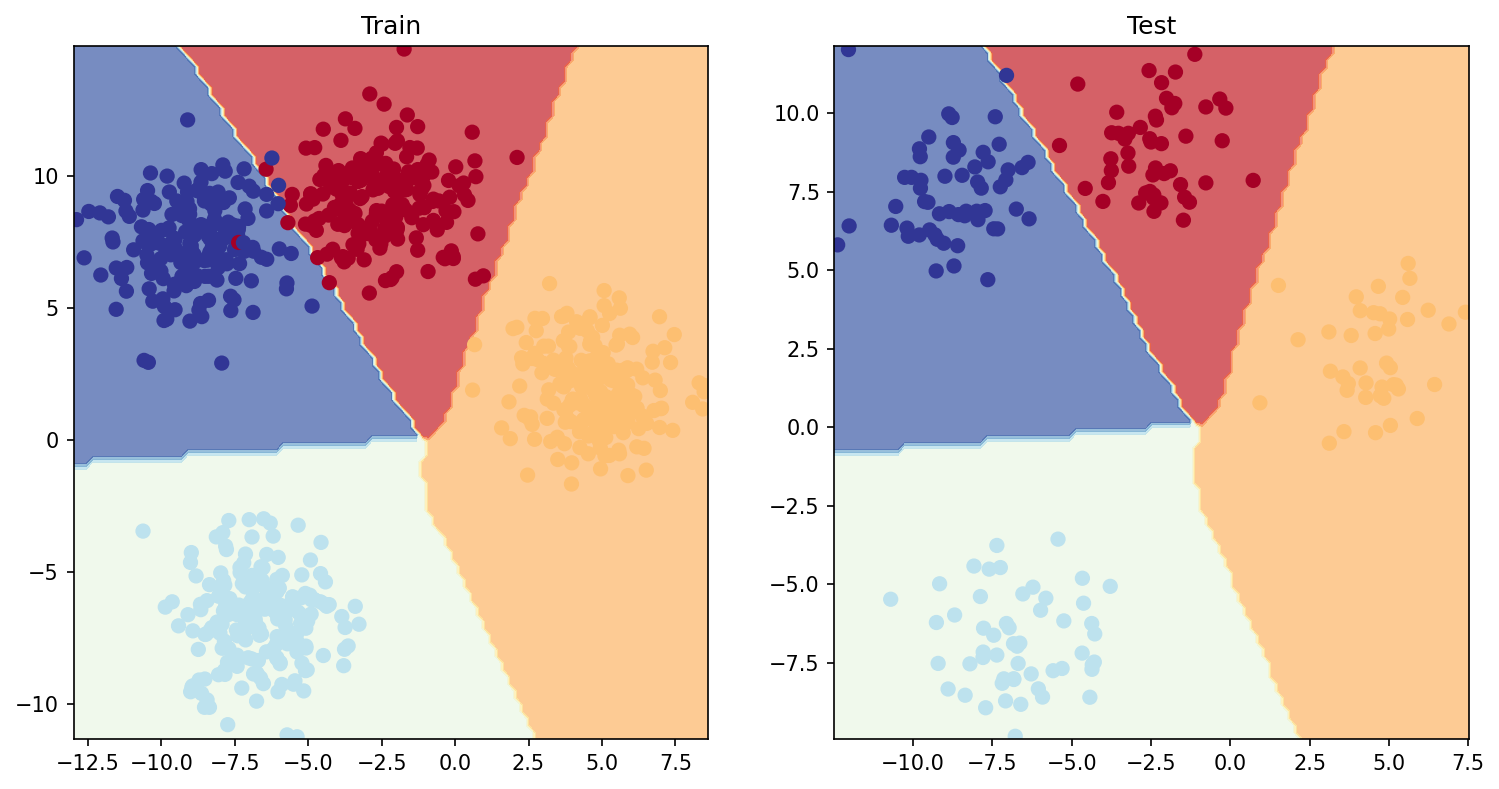

In [30]:
plt.figure(figsize=(12, 6), dpi=150)
plt.subplot(1, 2, 1)
plt.title("Train")
plot_decision_boundary(blob_model, X_blob_train, y_blob_train)

plt.subplot(1, 2, 2)
plt.title("Test")
plot_decision_boundary(blob_model, X_blob_test, y_blob_test)
